# SPGUE.jl
Example usage

## Load necessary modules

In [1]:
push!(LOAD_PATH, pwd())
using CUDA, SPGPUE, BenchmarkTools, Plots

## Initialize parameters and observables

In [2]:
par = Params(
    NBEC = 3e3, # number of atoms in the gas cloud
    g = 2, # inter-atomic interaction strength 
    gamma = 5e-1, # number-damping rate
    T = 1e-5, # temperature of the gas cloud
    Tf = 2*2*pi, # time-evolution duration
    cutoff = 20) # number of harmonic oscillator modes
cn_ini = randn(Complex{Float32},par.modes,1) # random mode configuration as initial state
opr = Operators(par,cn_ini);
time = par.dt*(1:par.steps)
energy = zeros(par.steps,1)
atoms = zeros(par.steps,1)
groundstate = zeros(par.steps,1);

## Evolve random initial state

In [8]:
@time begin
CUDA.allowscalar(true)
for i = 1:par.steps
    evolve!(par, opr)
    energy[i] = (transpose(opr.en)*abs2.(opr.cn) + 0.5*real(opr.cn'*opr.Gn))[1]
    atoms[i] = sum(abs2.(opr.cn))
    groundstate[i] = abs2(opr.cn[1])
end
end

 22.586242 seconds (3.79 M allocations: 231.112 MiB, 0.61% gc time)


## Plot energy, number of atoms and lowest-energy state occupancy

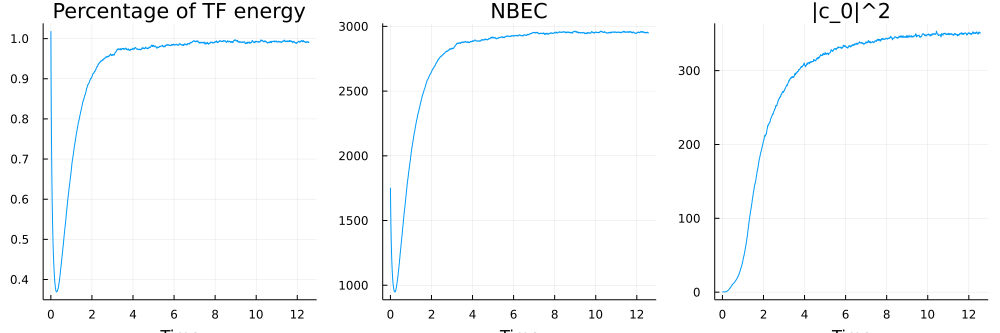

In [4]:
p1 = plot(time,energy/par.ETF,title="Percentage of TF energy")
p2 = plot(time,atoms,title="NBEC")
p3 = plot(time,groundstate,title="|c_0|^2")
plot(p1, p2, p3, layout = (1, 3), size = (1000, 333), legend = false, xlabel="Time")

## Compute wave function and plot column density and phase

In [5]:
plotgrid, posmax = 128, 10.0
dx = 2*posmax/plotgrid
x, wf = draw_wf(par,opr.cn,plotgrid,posmax);

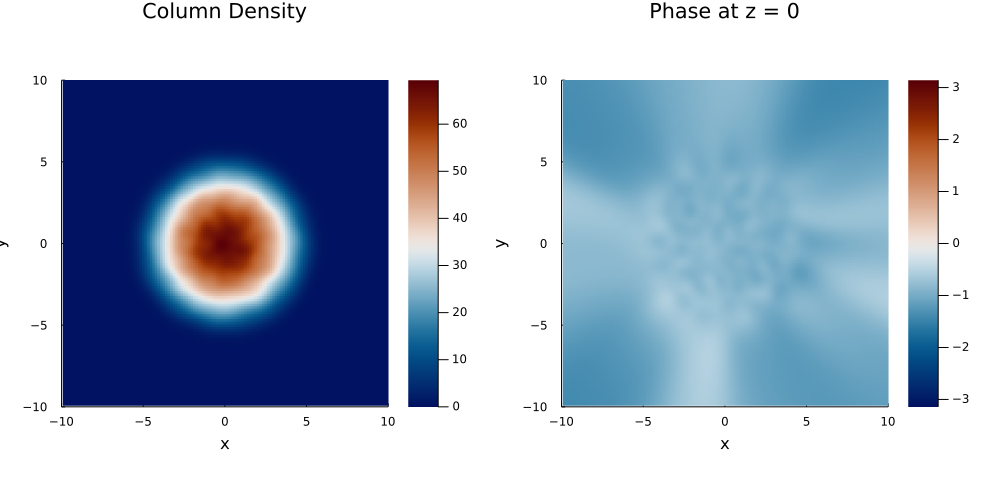

In [6]:
p1 = heatmap(x,x,dropdims(sum(abs2.(wf),dims=3),dims=3).*dx,aspect_ratio=:equal,xlims=(-posmax,posmax),ylims=(-posmax,posmax),color=:vik,xlabel="x",ylabel="y",title="Column Density")
p2 = heatmap(x,x,angle.(wf[:,:,Int(plotgrid/2)]),aspect_ratio=:equal,xlims=(-posmax,posmax),ylims=(-posmax,posmax),color=:vik,clims=(-pi,pi),xlabel="x",ylabel="y",title="Phase at z = 0")
plot(p1, p2, layout = (1, 2), size = (1000, 500))

## Compare with Thomas-Fermi approximation

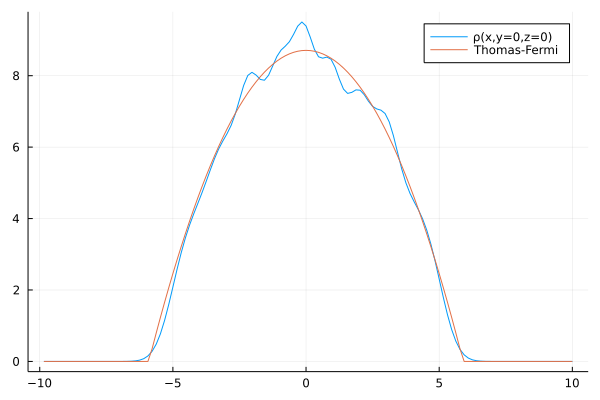

In [7]:
wfTF = @. real(sqrt(Complex(par.muTF - 0.5*x^2)/par.g))
plot(x,[abs2.(wf[:,Int(plotgrid/2),Int(plotgrid/2)]) abs2.(wfTF)], label=["ρ(x,y=0,z=0)" "Thomas-Fermi"])